<a href="https://colab.research.google.com/github/Gavin-Moss/Python-for-Math/blob/main/Exploration_2_Newtons_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

The effect of Newton's Method on a linear equation is trivial, so let's start our exporation with its effect on quadratics.

Real line, quadratic:

In [ ]:
# A function that takes in the coefficients of a polynomial and an x value, then returns a y value
def poly_point(poly_coeffs, x):
  degree = len(poly_coeffs) - 1
  result = 0
  for i in range(degree + 1):
    result += poly_coeffs[i] * x ** (degree - i)
  return result

# A function that takes in the coefficients of a polynomial and an x value, then returns its derivative at that value
def poly_dev(poly_coeffs, x):
  new_coeffs = np.arange(len(poly_coeffs))[:0:-1] * np.array(poly_coeffs)[:-1]
  return poly_point(new_coeffs, x)

In [ ]:
# A function that does Newton's Method
def poly_newton(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    c += 1
  if c == 200:
    return np.pi
  return round(x1, precision)

In [ ]:
# A function that takes in n, then returns the RGB values of n "evenly spaced" colors
def evenly_spaced_colors(n):
  colors = np.zeros([n+1, 3], dtype='uint8')
  x_values = np.linspace(0, 1535, n+1, dtype='int')
  for i in range(n+1):
    if x_values[i] in range(0, 256):
      colors[i] = [255, x_values[i], 0]
    elif x_values[i] in range(256, 512):
      colors[i] = [-1-x_values[i], 255, 0]
    elif x_values[i] in range(512, 768):
      colors[i] = [0, 255, x_values[i]]
    elif x_values[i] in range(768, 1024):
      colors[i] = [0, -1-x_values[i], 255]
    elif x_values[i] in range(1024, 1280):
      colors[i] = [x_values[i], 0, 255]
    elif x_values[i] in range(1280, 1536):
      colors[i] = [255, 0, -1-x_values[i]]
  return colors[:-1]

In [ ]:
poly_newton([1, 0, -2], 1.5, 4)

1.4142

In [ ]:
def draw_1D_poly_NM(poly_coeffs, x_int, x_fin, res=500, height=100):
  x_destinations = np.zeros(res)
  x_values = np.linspace(x_int, x_fin, res)
  for i in range(res):
    x_destinations[i] = poly_newton(poly_coeffs, x_values[i], 8)
  bins = []
  for i in range(res):
    if x_destinations[i] not in bins:
      bins.append(x_destinations[i])
  if np.pi in bins:
    colors = evenly_spaced_colors(len(bins) - 1)
    bins.remove(np.pi)
  else:
    colors = evenly_spaced_colors(len(bins))
  print(bins)
  print(colors)
  colors_dict = {}
  for i in range(len(bins)):
    colors_dict[bins[i]] = colors[i]
  print(colors_dict)
  img_arr = np.zeros([height, res, 3], dtype='uint8')
  for i in range(res):
    if x_destinations[i] != np.pi:
      img_arr[:, i] = colors_dict[x_destinations[i]]
  img = Image.fromarray(img_arr)
  display(img)

[-2.69747248, -0.6332411, 0.31356943, -2.22926221]
[[255   0   0]
 [128 255   0]
 [  0 255 255]
 [127   0 255]]
{-2.69747248: array([255,   0,   0], dtype=uint8), -0.6332411: array([128, 255,   0], dtype=uint8), 0.31356943: array([  0, 255, 255], dtype=uint8), -2.22926221: array([127,   0, 255], dtype=uint8)}


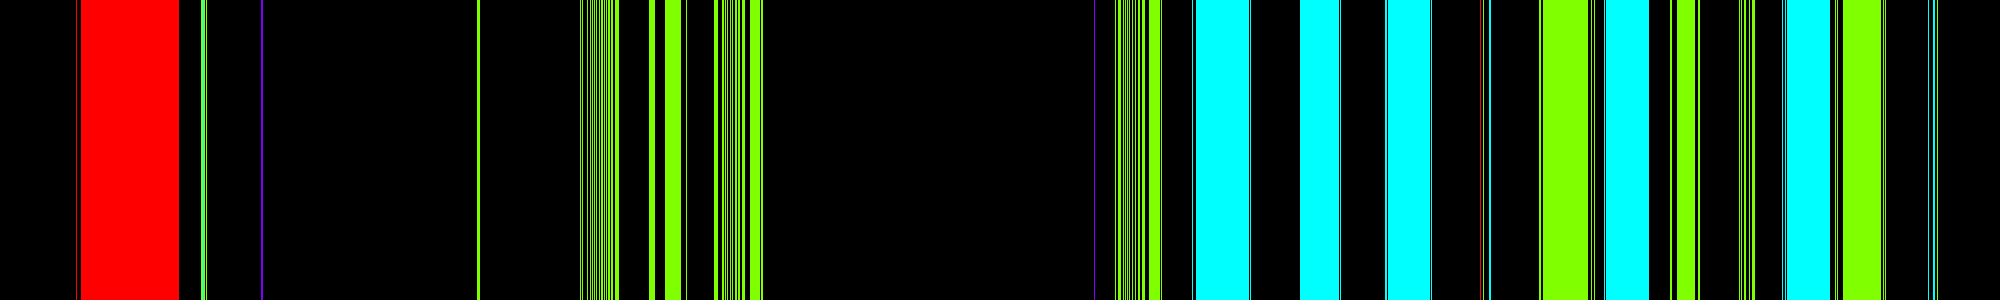

In [ ]:
draw_1D_poly_NM([-0.3, -0.9, 0.9, 2.5, -2.1, -1.2, 0.5], -3, 2, res=2000, height=300)